<a href="https://colab.research.google.com/github/pockerman/hidden_markov_modeling/blob/master/stories/story_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Story 51


Chromosome 11


Apply ```HMM_Model_9.json``` in regions: 

* [R1: ```region_0_REGION_1_CHR_11_MEAN_CUTOFF.txt```,  1000000-20000000](#r1)
* [R2: ```region_0_REGION_2_CHR_11_MEAN_CUTOFF.txt```,  20000000-40000000](#r2) 
* [R3: ```region_0_REGION_3_CHR_11_MEAN_CUTOFF.txt```,  40000000-50000000](#r3)
* [R4: ```region_0_REGION_4_CHR_11_MEAN_CUTOFF.txt```,  56000000-76000000](#r4)
* [R5: ```region_0_REGION_5_CHR_11_MEAN_CUTOFF.txt```,  76000000-96000000](#r5)
* [R6: ```region_0_REGION_6_CHR_11_MEAN_CUTOFF.txt```,  96000000-116000000](#r6)
* [R7: ```region_0_REGION_7_CHR_11_MEAN_CUTOFF.txt```,  116000000-126000000](#r7)

In [8]:
import numpy as np
from pomegranate import *
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
from helpers import read_configuration_file, INFO, WARNING
from train import load_regions
from hmm_helpers import build_hmm
from helpers import WindowType
from preprocess_utils import get_distributions_list_from_names as get_dist_list
from region import Region

In [10]:
from notebooks_helpers import filter_viterbi_path
from notebooks_helpers import save_segments
from notebooks_helpers import load_data_file
from notebooks_helpers import get_start_end_segment
from notebooks_helpers import make_data_array
from notebooks_helpers import gmm_clustering
from notebooks_helpers import create_viterbi_path
from notebooks_helpers import create_states
from notebooks_helpers import create_tuf_state
from notebooks_helpers import get_states_counter
from notebooks_helpers import plot_hmm_states_to_labels
from notebooks_helpers import plot_hmm_label_state
from notebooks_helpers import plot_hmm_cluster_contours

In [11]:
sns.set(color_codes=True)

Orphan state HMM_Model-start removed due to no edges                             leading to it
Orphan state HMM_Model-end removed due to no edges                             leading to it


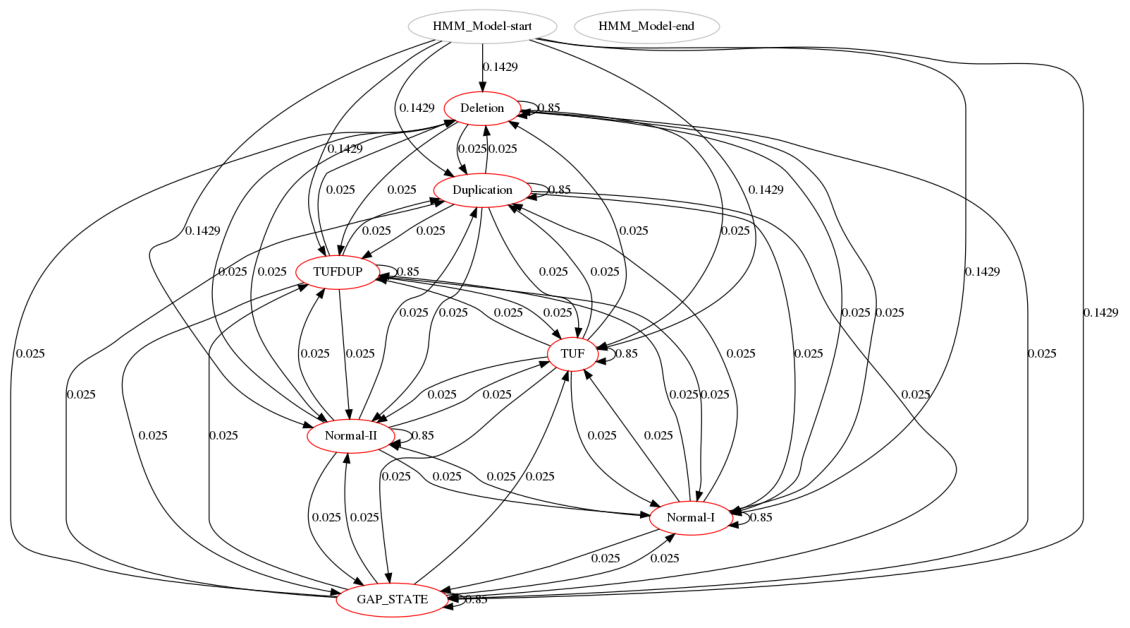

In [12]:
# load the configuration
configuration = read_configuration_file("../config.json")
hmm_config = configuration["HMM"]
hmm_filename = "HMM_Model_9.json"
hmm_model = build_hmm(hmm_file=hmm_filename)
# visualize the model we just trained
plt.figure( figsize=(20,18) )
hmm_model.plot()
plt.show()

## <a name="r1"></a>  Region 1

In [13]:
chr='chr11'
viterbi_paths = 'viterbi_paths_chr11/'

In [14]:
# load the region we want to use for prediction
region_name = "region_0_REGION_1_CHR_11_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_1_CHR_11_MEAN_CUTOFF.txt
Sequence length:  189989


In [15]:
filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model,
                                                                         chr=chr,
                                                                         filename=filename)

Observation length:  189989
Done. Execution time 0.7401382829993963 secs
Log-probability of ML Viterbi path:  -1299719.3448054413
Viterbi path length:  189990
There should be 0 gaps


In [16]:
# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

Length of path  189989
Length of TUF+DELETION+TUF state:  3293


In [17]:
wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

Length of WGA Observations:  189989
Encountered gaps:  0


In [18]:
states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

{'Duplication': 130, 'Normal-I': 123158, 'Normal-II': 59399, 'Deletion': 339, 'Single-Deletion': 0, 'TUF': 6949, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 14}


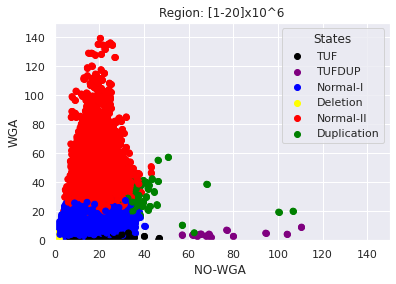

HMM labels color:  {'black': [5, 6949], 'purple': [6, 14], 'blue': [1, 123158], 'yellow': [3, 339], 'red': [2, 59399], 'green': [0, 130]}


In [19]:
hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [1-20]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

In [20]:
for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

State:  Duplication
WGA mean/var:  27.93876923076923 55.683903100591714
NO-WGA mean/var:  36.55292307692307 107.3336314556213
State:  Normal-I
WGA mean/var:  16.168473424381688 28.473096710636078
NO-WGA mean/var:  17.744091979408566 22.70586135050957
State:  Normal-II
WGA mean/var:  32.649141568039866 89.45824694234842
NO-WGA mean/var:  18.970806410882332 19.446316065471112
State:  Deletion
WGA mean/var:  1.4234513274336282 1.9532172918787687
NO-WGA mean/var:  2.1500589970501474 1.8206253652509115
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.411913944452439 2.644071743349947
NO-WGA mean/var:  13.567821269247373 21.79915867232931
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP
WGA mean/var:  4.327142857142857 3.0446918367346933
NO-WGA mean/var:  74.91 257.7416714285714


## <a name="r2"></a> Region 2

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_2_CHR_11_MEAN_CUTOFF.txt
Sequence length:  199999
Observation length:  199999
Done. Execution time 0.6251518159988336 secs
Log-probability of ML Viterbi path:  -1344202.1300927163
Viterbi path length:  200000
There should be 0 gaps
Length of path  199999
Length of TUF+DELETION+TUF state:  9
Length of WGA Observations:  199999
Encountered gaps:  0
{'Duplication': 74, 'Normal-I': 155371, 'Normal-II': 43884, 'Deletion': 90, 'Single-Deletion': 0, 'TUF': 580, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


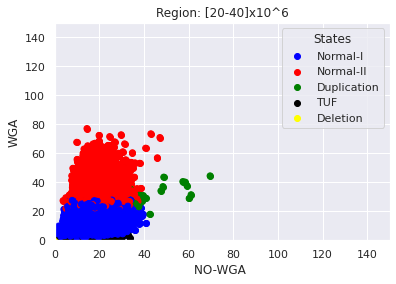

HMM labels color:  {'blue': [1, 155371], 'red': [2, 43884], 'green': [0, 74], 'black': [5, 580], 'yellow': [3, 90]}
State:  Duplication
WGA mean/var:  26.14662162162162 31.796630478451426
NO-WGA mean/var:  36.70283783783785 70.71357708181155
State:  Normal-I
WGA mean/var:  16.441529886529658 23.185945208217568
NO-WGA mean/var:  19.360257705749465 20.785138879723124
State:  Normal-II
WGA mean/var:  30.06146682162064 41.161079083052876
NO-WGA mean/var:  20.07652356211831 18.653288784856368
State:  Deletion
WGA mean/var:  1.6982222222222223 1.630696839506173
NO-WGA mean/var:  1.733666666666667 1.606532111111111
State:  Single-Deletion
State:  TUF
WGA mean/var:  3.051396551724138 1.9340802910225923
NO-WGA mean/var:  15.648172413793102 29.493976659928652
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [21]:
# load the region we want to use for prediction
region_name = "region_0_REGION_2_CHR_11_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [20-40]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r3"></a>  Region 3

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_3_CHR_11_MEAN_CUTOFF.txt
Sequence length:  99997
Observation length:  99997
Done. Execution time 0.26654019899979176 secs
Log-probability of ML Viterbi path:  -679259.6004516678
Viterbi path length:  99998
There should be 0 gaps
Length of path  99997
Length of TUF+DELETION+TUF state:  49
Length of WGA Observations:  99997
Encountered gaps:  0
{'Duplication': 36, 'Normal-I': 73070, 'Normal-II': 25723, 'Deletion': 55, 'Single-Deletion': 0, 'TUF': 1113, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


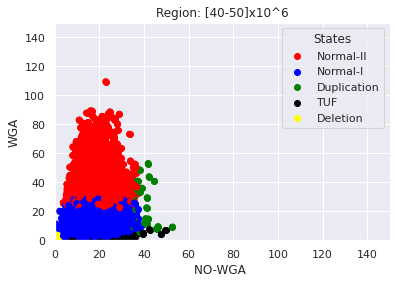

HMM labels color:  {'red': [2, 25723], 'blue': [1, 73070], 'green': [0, 36], 'black': [5, 1113], 'yellow': [3, 55]}
State:  Duplication
WGA mean/var:  25.6175 141.26246319444442
NO-WGA mean/var:  37.22416666666666 29.17060208333333
State:  Normal-I
WGA mean/var:  16.595344737922538 24.819258002819918
NO-WGA mean/var:  18.353770220336663 22.17816772467496
State:  Normal-II
WGA mean/var:  31.512690588189557 67.66929409028462
NO-WGA mean/var:  18.947029506667185 20.382654850701876
State:  Deletion
WGA mean/var:  1.1325454545454545 1.5284480661157025
NO-WGA mean/var:  1.3040000000000003 1.5464676363636365
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.9899999999999998 1.7299061994609164
NO-WGA mean/var:  19.922353998203057 36.046522041801175
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [22]:
# load the region we want to use for prediction
region_name = "region_0_REGION_3_CHR_11_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [40-50]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r4"></a>  Region 4

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_4_CHR_11_MEAN_CUTOFF.txt
Sequence length:  199998
Observation length:  199998
Done. Execution time 0.7073359719997825 secs
Log-probability of ML Viterbi path:  -1345125.2538784938
Viterbi path length:  199999
There should be 1001 gaps
Length of path  199998
Length of TUF+DELETION+TUF state:  476
Length of WGA Observations:  198997
Encountered gaps:  1001
{'Duplication': 81, 'Normal-I': 144838, 'Normal-II': 50433, 'Deletion': 84, 'Single-Deletion': 0, 'TUF': 3561, 'GAP_STATE': 1001, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


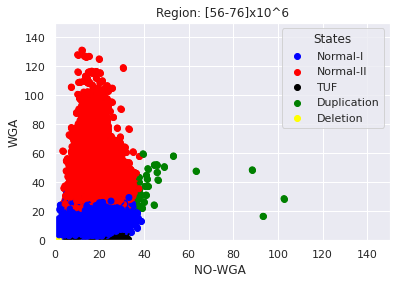

HMM labels color:  {'blue': [1, 144838], 'red': [2, 50433], 'black': [5, 3561], 'green': [0, 81], 'yellow': [3, 84]}
State:  Duplication
WGA mean/var:  30.805925925925923 89.36499945130315
NO-WGA mean/var:  37.928148148148146 161.83035089163235
State:  Normal-I
WGA mean/var:  15.865375799168724 27.584184278264342
NO-WGA mean/var:  16.830393266960332 21.586694120324182
State:  Normal-II
WGA mean/var:  32.80588186306585 96.14156928209981
NO-WGA mean/var:  17.82491186326413 20.56582725265664
State:  Deletion
WGA mean/var:  1.3939285714285714 2.0766143282312925
NO-WGA mean/var:  1.8644047619047623 1.6625651218820865
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.8514069081718616 2.4643838391996797
NO-WGA mean/var:  13.91253299634934 19.405865586176052
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [23]:
# load the region we want to use for prediction
region_name = "region_0_REGION_4_CHR_11_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [56-76]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r5"></a>  Region 5

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_5_CHR_11_MEAN_CUTOFF.txt
Sequence length:  199991
Observation length:  199991
Done. Execution time 0.9699440469994443 secs
Log-probability of ML Viterbi path:  -1368888.2866699127
Viterbi path length:  199992
There should be 247 gaps
Length of path  199991
Length of TUF+DELETION+TUF state:  100
Length of WGA Observations:  199744
Encountered gaps:  247
{'Duplication': 320, 'Normal-I': 142311, 'Normal-II': 56245, 'Deletion': 111, 'Single-Deletion': 0, 'TUF': 757, 'GAP_STATE': 247, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


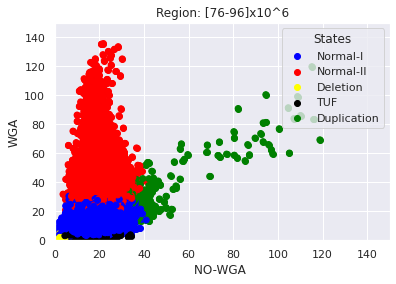

HMM labels color:  {'blue': [1, 142311], 'red': [2, 56245], 'yellow': [3, 111], 'black': [5, 757], 'green': [0, 320]}
State:  Duplication
WGA mean/var:  31.131375000000002 278.25439998437497
NO-WGA mean/var:  42.58071875 323.3565441708985
State:  Normal-I
WGA mean/var:  16.753490383737024 23.245363181037234
NO-WGA mean/var:  19.01842963650034 21.45483691390803
State:  Normal-II
WGA mean/var:  31.30967037069962 77.52377879080225
NO-WGA mean/var:  19.851970130678282 18.768712059557636
State:  Deletion
WGA mean/var:  1.2883783783783782 1.1740334063793523
NO-WGA mean/var:  1.9628828828828833 1.955818716013311
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.9582694848084543 2.2752021572326275
NO-WGA mean/var:  15.466010568031702 27.550826356559387
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [24]:
# load the region we want to use for prediction
region_name = "region_0_REGION_5_CHR_11_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs,
                          title="Region: [76-96]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## <a name="r6"></a>  Region 6 

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_6_CHR_11_MEAN_CUTOFF.txt
Sequence length:  200000
Observation length:  200000
Done. Execution time 0.8180137069994089 secs
Log-probability of ML Viterbi path:  -1351527.3832823995
Viterbi path length:  200001
There should be 3 gaps
Length of path  200000
Length of TUF+DELETION+TUF state:  141
Length of WGA Observations:  199997
Encountered gaps:  3
{'Duplication': 118, 'Normal-I': 148236, 'Normal-II': 50976, 'Deletion': 34, 'Single-Deletion': 0, 'TUF': 633, 'GAP_STATE': 3, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


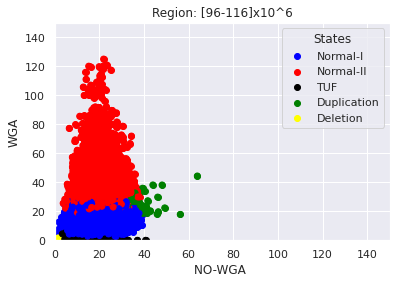

HMM labels color:  {'blue': [1, 148236], 'red': [2, 50976], 'black': [5, 633], 'green': [0, 118], 'yellow': [3, 34]}
State:  Duplication
WGA mean/var:  25.385 21.27933686440678
NO-WGA mean/var:  35.12338983050848 30.353098678540647
State:  Normal-I
WGA mean/var:  16.49680286839904 23.139474761079764
NO-WGA mean/var:  19.20693468523166 21.078720545964696
State:  Normal-II
WGA mean/var:  31.497439383239175 69.76170000515329
NO-WGA mean/var:  19.736210569679848 18.933855004232285
State:  Deletion
WGA mean/var:  1.4629411764705882 1.0882442906574394
NO-WGA mean/var:  2.225294117647059 1.2386660899653978
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.823949447077409 2.3388656024996943
NO-WGA mean/var:  15.281579778830963 38.30985406038099
State:  GAP_STATE
WGA mean/var:  -999.0 0.0
NO-WGA mean/var:  -999.0 0.0
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [25]:
# load the region we want to use for prediction
region_name = "region_0_REGION_6_CHR_11_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [96-116]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))

## Region 7

INFO: Loading region from file: /home/alex/qi3/hidden_markov_modeling/data/region_0_REGION_7_CHR_11_MEAN_CUTOFF.txt
Sequence length:  100000
Observation length:  100000
Done. Execution time 0.3603372659999877 secs
Log-probability of ML Viterbi path:  -693150.3136404379
Viterbi path length:  100001
There should be 0 gaps
Length of path  100000
Length of TUF+DELETION+TUF state:  104
Length of WGA Observations:  100000
Encountered gaps:  0
{'Duplication': 45, 'Normal-I': 60991, 'Normal-II': 38197, 'Deletion': 34, 'Single-Deletion': 0, 'TUF': 733, 'GAP_STATE': 0, 'GAP_STATE_INCORRECT': 0, 'TUFDUP': 0}


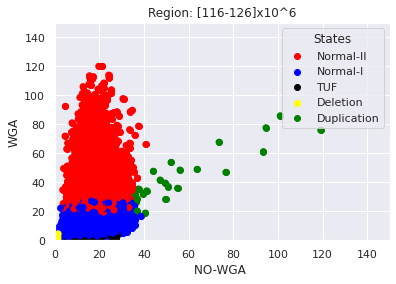

HMM labels color:  {'red': [2, 38197], 'blue': [1, 60991], 'black': [5, 733], 'yellow': [3, 34], 'green': [0, 45]}
State:  Duplication
WGA mean/var:  35.672888888888885 258.6578560987654
NO-WGA mean/var:  45.51866666666667 442.9471715555555
State:  Normal-I
WGA mean/var:  16.79389303339837 25.730431513471657
NO-WGA mean/var:  17.34366906592776 20.776724191051578
State:  Normal-II
WGA mean/var:  34.24162054611619 112.85231157128035
NO-WGA mean/var:  18.025757782024762 19.35632391001909
State:  Deletion
WGA mean/var:  1.1826470588235294 1.3859371107266436
NO-WGA mean/var:  1.6679411764705883 1.496981055363322
State:  Single-Deletion
State:  TUF
WGA mean/var:  2.741705320600273 2.4663003660972027
NO-WGA mean/var:  15.04682128240109 18.179121819356062
State:  GAP_STATE
State:  GAP_STATE_INCORRECT
State:  TUFDUP


In [26]:
# load the region we want to use for prediction
region_name = "region_0_REGION_7_CHR_11_MEAN_CUTOFF.txt"
region_file = "/home/alex/qi3/hidden_markov_modeling/data/" + region_name 
region = Region.load(filename=region_file)
region.check_windows_sanity()
mixed_windows = region.get_mixed_windows()

# load a sequence including the gaps
sequence = region.get_region_as_rd_mean_sequences_with_windows(size=None,
                                                               window_type=WindowType.from_string(hmm_config["train_windowtype"]),
                                                                n_seqs=hmm_config["train_n_sequences_per_source"],
                                                                exclude_gaps=False)

print("Sequence length: ", len(sequence))

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths

filename = filename + "viterbi_path_" + region_name
viterbi_path, observations, sequence_viterbi_state = create_viterbi_path(sequence=sequence, 
                                                                         hmm_model=hmm_model, 
                                                                         chr=chr,
                                                                         filename=filename)

# extract the tuf + Deletion + tuf
tuf_delete_tuf = filter_viterbi_path(path=viterbi_path[1][1:],
                                    wstate='TUF', limit_state='Deletion',
                                    min_subsequence=1)

print("Length of TUF+DELETION+TUF state: ", len(tuf_delete_tuf))

segments = get_start_end_segment(tuf_delete_tuf, sequence)

filename = "/home/alex/qi3/hidden_markov_modeling/stories/" + viterbi_paths
filename = filename + "tuf_delete_tuf_" + region_name
save_segments(segments=segments, chromosome=chr, filename=filename)

wga_obs = []
no_wga_obs = []
no_gaps_obs = []

for obs in observations:
    
    # do not account for gaps
    if obs != (-999.0, -999.0):
        wga_obs.append(obs[0])
        no_wga_obs.append(obs[1])
        no_gaps_obs.append((obs[1], obs[0]))
 
print("Length of WGA Observations: ", len(wga_obs))
print("Encountered gaps: ", len(observations) - len(wga_obs))
nbins = 80

states_counter = {"Duplication": 0, "Normal-I": 0, "Normal-II":0, 
                  "Deletion": 0, "Single-Deletion": 0, "TUF": 0,
                  "GAP_STATE": 0, "GAP_STATE_INCORRECT":0, 'TUFDUP':0}

states_counter, state_data = get_states_counter(states_counter=states_counter,
                                   observations=observations,
                                   sequence_viterbi_state=sequence_viterbi_state)
print(states_counter) 

hmm_states_to_labels = {"Duplication": 0, "Normal-I": 1, "Normal-II":2, 
                        "Deletion": 3, "Single-Deletion": 4, "TUF": 5, "TUFDUP":6}

color_comp_assoc_hmm, hmm_states_to_labels, hmm_labels = \
plot_hmm_states_to_labels(hmm_states_to_labels=hmm_states_to_labels,
                          observations=observations, 
                          sequence_viterbi_state=sequence_viterbi_state, 
                          no_wga_obs=no_wga_obs, wga_obs=wga_obs, 
                          title="Region: [116-126]x10^6",
                          xlim=(0.0, 150.), ylim=(0.0, 150.0))
print("HMM labels color: ", color_comp_assoc_hmm)

for state in state_data:
    print("State: ", state)
    
    if len(state_data[state][0]) == 0:
        continue
    
    print("WGA mean/var: ", np.mean(state_data[state][0]), np.var(state_data[state][0]))
    print("NO-WGA mean/var: ", np.mean(state_data[state][1]), np.var(state_data[state][1]))